# Yeast Polarization CDC 42
***
Yeast Polarization CDC 42 cycle 2D simulated using SDPD
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../..')))

In [2]:
import math
import numpy

MatPlotLib is used for creating custom visualizations

In [3]:
import matplotlib.pyplot as plt

In [4]:
import spatialpy

***
## Create Geometries for the Domain
***

In [5]:
class Membrane(spatialpy.Geometry):
    def __init__(self, radius_external, radius_internal):
        spatialpy.Geometry.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, point, on_boundary):
        r = numpy.sqrt(point[0]**2 + point[1]**2)
        return self.radius_external >= r >= self.radius_internal

In [6]:
class Cytoplasm(spatialpy.Geometry):
    def __init__(self, radius_external, radius_internal):
        spatialpy.Geometry.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, point, on_boundary):
        r = numpy.sqrt(point[0]**2 + point[1]**2)
        return r < self.radius_internal

***
## Create the Data Functions for the System
***

In [7]:
class GbgGradient(spatialpy.DataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0, mem_vol=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope
        self.mem_vol = mem_vol
        
    def expression(self):
        return f"({self.Gbg_slope} * me->x[1] + {self.Gbg_mid}) / {self.mem_vol}"
    
    def map(self, x):
        return (self.Gbg_slope * x[1] + self.Gbg_mid) / self.mem_vol

***
## Create the Yeast Polarization CDC 42 Model
***

In [8]:
def create_cdc42_model(model_name="Cdc42_2D", end_time=1000, DX=10, parameter_values=None):
    # Initialize Model
    model = spatialpy.Model(model_name)

    # Define Domain Type IDs as constants of the Model
    model.EXTRA_CELLULAR = "Extra_Cellular"
    model.MEMBRANE = Membrane.__name__
    model.CYTOPLASM = Cytoplasm.__name__

    # System constants
    Gbg_conc = 5000.0
    Gbg_pct_slope = 0.0
    delta1_val = 0.00297
    delta1_gbg_val = 0.00297
    delta_neg_val = 1.0 / 30000
    radius_external = 0.6
    radius_internal = 0.4
    D_membrane = 0.0053 # diffusion on the membrane from PLOS paper
    D_GDP = 0.0053
    D_GTP = 0.0053
    D_bulk = 10.0

    # Define Domain
    domain = spatialpy.Domain.create_2D_domain(
        xlim=(-1, 1), ylim=(-1, 1), numx=DX, numy=DX, rho0=1.0, c0=10, P0=10, type_id=model.EXTRA_CELLULAR
    )
    
    # Add Type IDs to the Particles
    domain.set_properties(
        Membrane(radius_external, radius_internal), type_id=model.MEMBRANE, mass=4.0, nu=1.0, fixed=False
    )
    domain.set_properties(
        Cytoplasm(radius_external, radius_internal), type_id=model.CYTOPLASM, mass=2.0, nu=1.0, fixed=False
    )
    
    # Set Models Domain
    model.add_domain(domain)

    # Define Variables (SpatialPy.Species)
    Cdc24_m = spatialpy.Species(
        name="Cdc24_m", diffusion_coefficient=D_membrane, restrict_to=model.MEMBRANE
    )
    Cdc24_c = spatialpy.Species(
        name="Cdc24_c", diffusion_coefficient=D_bulk, restrict_to=[model.MEMBRANE, model.CYTOPLASM]
    )
    Cdc42 = spatialpy.Species(name="Cdc42", diffusion_coefficient=D_GDP, restrict_to=model.MEMBRANE)
    Cdc42_a = spatialpy.Species(name="Cdc42_a", diffusion_coefficient=D_GTP, restrict_to=model.MEMBRANE)
    Bem1_m = spatialpy.Species(name="Bem1_m", diffusion_coefficient=D_membrane, restrict_to=model.MEMBRANE)
    Bem1_c = spatialpy.Species(
        name="Bem1_c", diffusion_coefficient=D_bulk, restrict_to=[model.MEMBRANE, model.CYTOPLASM]
    )
    Cla4 = spatialpy.Species(
        name="Cla4", diffusion_coefficient=D_bulk, restrict_to=[model.MEMBRANE, model.CYTOPLASM]
    )
    Cla4_a = spatialpy.Species(
        name="Cla4_a", diffusion_coefficient=D_membrane, restrict_to=model.MEMBRANE
    )
    Cdc42_c = spatialpy.Species(
        name="Cdc42_c", diffusion_coefficient=D_bulk, restrict_to=[model.MEMBRANE, model.CYTOPLASM]
    )
    
    # Add Variables to Model
    model.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])

    # Define Initial Conditions
    Cdc42_ic = spatialpy.ScatterInitialCondition(Cdc42, 2700, [model.CYTOPLASM])
    Cdc24_c_ic = spatialpy.ScatterInitialCondition(Cdc24_c, 1000, [model.MEMBRANE])
    Bem1_c_ic = spatialpy.ScatterInitialCondition(Bem1_c, 3000, [model.MEMBRANE])
    Cla4_ic = spatialpy.ScatterInitialCondition(Cla4, 5000, [model.MEMBRANE])
    Cdc42_a_ic = spatialpy.ScatterInitialCondition(Cdc42_a, 300, [model.CYTOPLASM])
    
    # Add Initial Conditions to Model
    model.add_initial_condition([Cdc42_ic, Cdc24_c_ic, Bem1_c_ic, Cla4_ic, Cdc42_a_ic])

    # Define Parameters
    k_42d = spatialpy.Parameter(name="k_42d", expression=1.0)
    k_42a = spatialpy.Parameter(name="k_42a", expression=0.2)
    k_24cm1 = spatialpy.Parameter(name="k_24cm1", expression=delta1_val)
    k_24mc = spatialpy.Parameter(name="k_24mc", expression=0.35) 
    k_B1mc = spatialpy.Parameter(name="k_B1mc", expression=0.35)
    k_B1cm = spatialpy.Parameter(name="k_B1cm", expression=0.2667)
    k_Cla4a = spatialpy.Parameter(name="k_Cla4a", expression=0.006)
    k_Cla4d = spatialpy.Parameter(name="k_Cla4d", expression=0.01)
    k_24d = spatialpy.Parameter(name="k_24d", expression=delta_neg_val)
    beta1 = spatialpy.Parameter(name="beta1", expression=0.266) 
    beta2 = spatialpy.Parameter(name="beta2", expression=0.28)
    beta3 = spatialpy.Parameter(name="beta3", expression=1.0) 
    delta1_gbg = spatialpy.Parameter(name="delta1_gbg", expression=delta1_gbg_val)

    # Add Parameters to Model
    model.add_parameter([
        k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d,k_24d,beta1, beta2, beta3,delta1_gbg
    ])

    # Reactions
    CR0 = spatialpy.Reaction(
        name="CR0", reactants={'Cdc24_c': 1}, products={'Cdc24_m': 1},
        propensity_function="delta1_gbg * Cdc24_c * GbgGradient * vol", restrict_to=model.MEMBRANE
    )
    CR1 = spatialpy.Reaction(
        name="CR1", reactants={'Cdc24_c': 1, 'Bem1_m': 1}, products={'Cdc24_m': 1, 'Bem1_m': 1},
        rate='k_24cm1', restrict_to=model.MEMBRANE
    )
    CR2 = spatialpy.Reaction(
        name="CR2", reactants={'Cdc24_m': 1}, products={'Cdc24_c': 1}, rate='k_24mc', restrict_to=model.MEMBRANE
    )
    CR3 = spatialpy.Reaction(
        name="CR3", reactants={'Cdc24_m': 1, 'Cla4_a': 1}, products={'Cdc24_c': 1 ,'Cla4_a': 1},
        rate='k_24d', restrict_to=model.MEMBRANE
    )
    CR4 = spatialpy.Reaction(
        name="CR4", reactants={'Cdc24_m': 1, 'Cdc42': 1}, products={'Cdc24_m': 1, 'Cdc42_a': 1},
        rate='k_42a', restrict_to=model.MEMBRANE
    )
    CR5 = spatialpy.Reaction(
        name="CR5", reactants={'Cdc42_a': 1}, products={'Cdc42': 1}, rate='k_42d', restrict_to=model.MEMBRANE
    )
    CR6 = spatialpy.Reaction(
        name="CR6", reactants={'Cdc42_a': 1, 'Bem1_c': 1}, products={'Cdc42_a': 1, 'Bem1_m': 1},
        rate='k_B1cm', restrict_to=model.MEMBRANE
    )
    CR7 = spatialpy.Reaction(
        name="CR7", reactants={'Bem1_m': 1}, products={'Bem1_c': 1}, rate='k_B1mc', restrict_to=model.MEMBRANE
    )
    CR8 = spatialpy.Reaction(
        name="CR8", reactants={'Cdc42_a': 1, 'Cla4': 1}, products={'Cdc42_a': 1, 'Cla4_a': 1},
        rate='k_Cla4a', restrict_to=model.MEMBRANE
    )
    CR9 = spatialpy.Reaction(
        name="CR9", reactants={'Cla4_a': 1}, products={'Cla4': 1}, rate='k_Cla4d', restrict_to=model.MEMBRANE
    )
    CR10 = spatialpy.Reaction(
        name="CR10", reactants={'Cdc42_c': 1}, products={'Cdc42': 1}, rate='beta2', restrict_to=model.MEMBRANE
    )
    CR11 = spatialpy.Reaction(
        name="CR11", reactants={'Cdc42': 1}, products={'Cdc42_c': 1}, rate='beta3', restrict_to=model.MEMBRANE
    )
    CR12 = spatialpy.Reaction(
        name="CR12", reactants={'Cdc42_c':1, 'Cdc24_m':1},
        products={'Cdc42_a': 1, 'Cdc24_m': 1}, rate='beta1', restrict_to=model.MEMBRANE
    )
    
    # Add Reactions to Model
    model.add_reaction([CR0, CR1, CR2, CR3, CR4, CR5, CR6, CR7, CR8, CR9, CR10, CR11, CR12])

    # Define Data Functions
    #################################################
    extra_cellular_volume = 0
    extra_cellular_count = 0
    membrane_volume = 0
    membrane_count = 0
    cytoplasm_volume = 0
    cytoplasm_count = 0
    for voxel_index, voxel_coords in enumerate(model.domain.coordinates()):
        if model.domain.type_id[voxel_index] == model.domain.get_type_def(model.EXTRA_CELLULAR):
            extra_cellular_volume = extra_cellular_volume + model.domain.vol[voxel_index]
            extra_cellular_count += 1
        elif model.domain.type_id[voxel_index] == model.domain.get_type_def(model.MEMBRANE):
            membrane_volume = membrane_volume + model.domain.vol[voxel_index]
            membrane_count += 1
        elif model.domain.type_id[voxel_index] == model.domain.get_type_def(model.CYTOPLASM):
            cytoplasm_volume = cytoplasm_volume + model.domain.vol[voxel_index]
            cytoplasm_count+=1

    true_cytoplasm_volume = math.pi * radius_internal * radius_internal
    true_membrane_volume = math.pi * radius_external * radius_external - true_cytoplasm_volume
    membrane_error = abs(true_membrane_volume - membrane_volume) / true_membrane_volume * 100
    cytoplasm_error = abs(true_cytoplasm_volume - cytoplasm_volume) / true_cytoplasm_volume * 100

    print(f"Volumes:  DX={DX}")
    print(f"\textracellular\t{extra_cellular_volume} ({extra_cellular_count} paticles)")
    print(f"\tmembrane\t{membrane_volume} ({membrane_count} paticles)\t{membrane_error:.2f}% error")
    print(f"\tcytoplasm\t{cytoplasm_volume} ({cytoplasm_count} paticles)\t{cytoplasm_error:.2f}% error")
    #################################################
    gbg_gradient = GbgGradient(
        Gbg_mid=Gbg_conc, Gbg_slope=Gbg_conc * Gbg_pct_slope / (radius_external * 2.0), mem_vol=membrane_volume
    )
    
    # Add Data Functions to Model
    model.add_data_function(gbg_gradient)

    # Define Timespan
    print("simulating to {0}s".format(end_time))
    num_steps = end_time + 1 if end_time >= 1.0 else 10
    tspan = spatialpy.TimeSpan.linspace(t=end_time, num_points=num_steps, timestep_size=1)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

### Particle Distribution Error Check
Check the particle distribution error over volume

In [9]:
for dx in range(10,100,10):
    model = create_cdc42_model(DX=dx)

Volumes:  DX=10
	extracellular	3.8800000000000026 (97 paticles)
	membrane	0.4799999999999999 (12 paticles)	23.61% error
	cytoplasm	0.4799999999999999 (12 paticles)	4.51% error
simulating to 1000s
Volumes:  DX=20
	extracellular	3.039999999999979 (304 paticles)
	membrane	0.5200000000000002 (52 paticles)	17.24% error
	cytoplasm	0.4400000000000002 (44 paticles)	12.46% error
simulating to 1000s
Volumes:  DX=30
	extracellular	2.9333333333333007 (660 paticles)
	membrane	0.5688888888888879 (128 paticles)	9.46% error
	cytoplasm	0.4977777777777763 (112 paticles)	0.97% error
simulating to 1000s
Volumes:  DX=40
	extracellular	2.919999999999949 (1168 paticles)
	membrane	0.5999999999999982 (240 paticles)	4.51% error
	cytoplasm	0.48000000000000037 (192 paticles)	4.51% error
simulating to 1000s
Volumes:  DX=50
	extracellular	2.9119999999999404 (1820 paticles)
	membrane	0.608000000000001 (380 paticles)	3.23% error
	cytoplasm	0.479999999999998 (300 paticles)	4.51% error
simulating to 1000s
Volumes:  DX=

### Instantiate the Model

In [10]:
model = create_cdc42_model(end_time=100)

Volumes:  DX=10
	extracellular	3.8800000000000026 (97 paticles)
	membrane	0.4799999999999999 (12 paticles)	23.61% error
	cytoplasm	0.4799999999999999 (12 paticles)	4.51% error
simulating to 100s


***
## Run the Simulation
***

In [11]:
%time result = model.run(debug_level=0)

CPU times: user 25.4 ms, sys: 10.1 ms, total: 35.5 ms
Wall time: 5min 13s


***
## Visualizations
****

In [12]:
Cdc42_vals = result.get_species("Cdc42_a", debug=False)

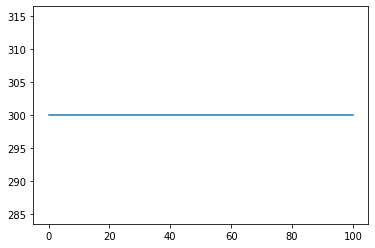

In [13]:
plt.plot(result.get_timespan(), Cdc42_vals.sum(axis=1))

In [14]:
type_vals = result.get_property("type", 0)

In [15]:
Cdc42_a_results = result.get_species("Cdc42_a", deterministic=True, debug=False)
print(numpy.amax(Cdc42_a_results))

nan


In [16]:
def plot_step(t_ndx, key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15, 10) )
    plt.scatter(pts[:, 0], pts[:, 1], c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title(f't={t_ndx}')
    
def plot_all(key='type'):
    for i, t in enumerate(result.get_timespan()):
        if i % 10 == 0:
            plot_step(i, key)

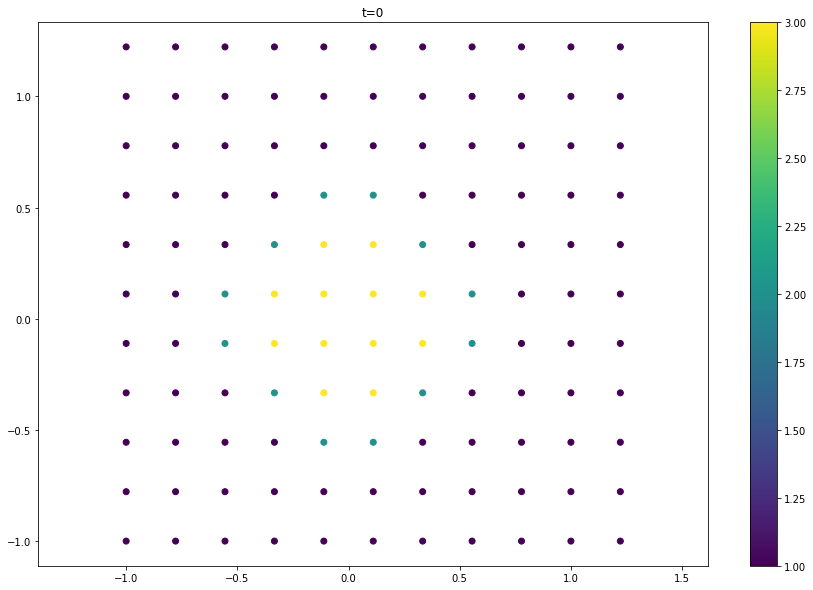

In [17]:
plot_step(0, key='type')

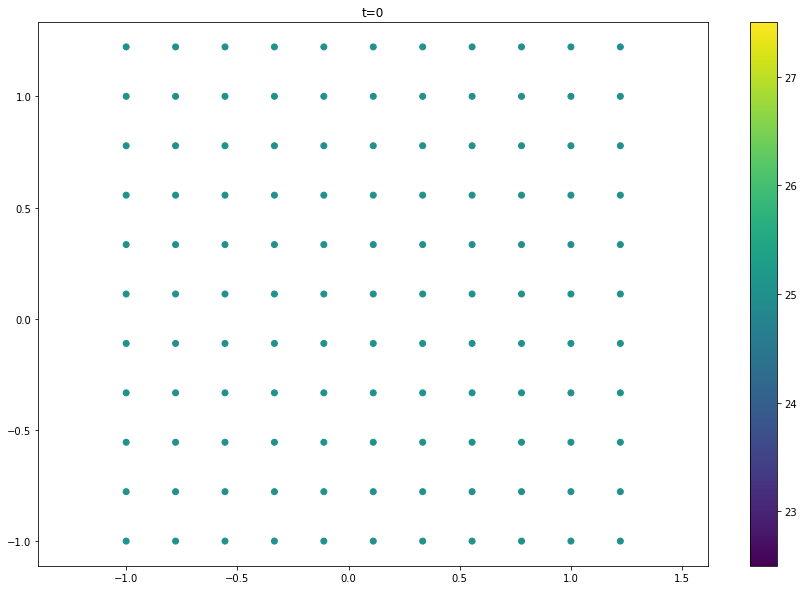

In [18]:
plot_step(0, key="rho")

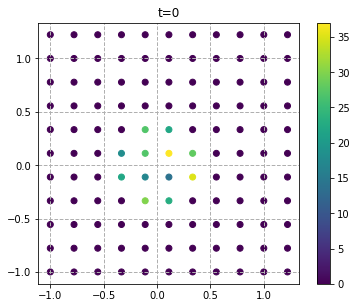

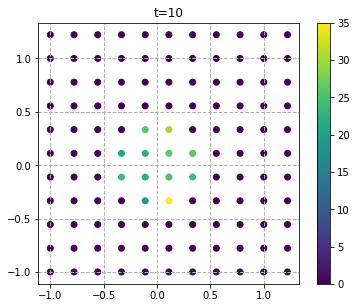

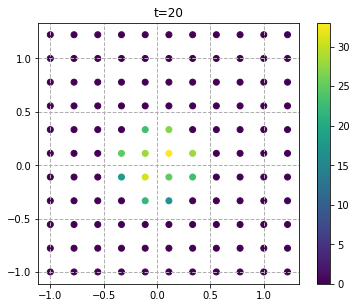

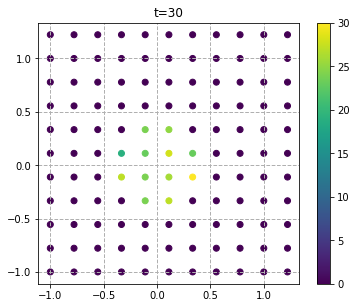

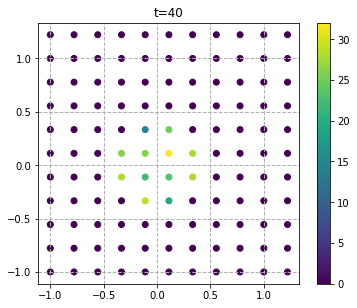

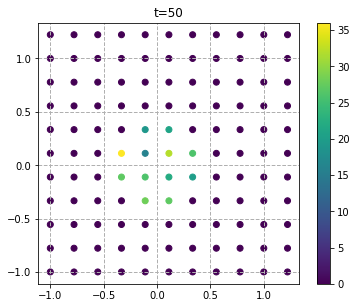

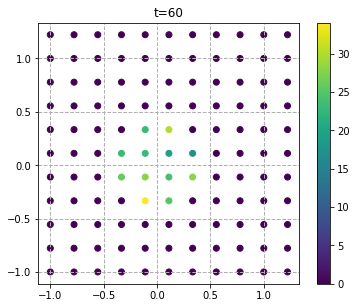

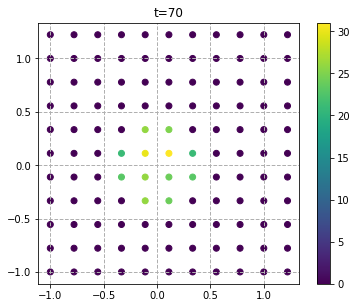

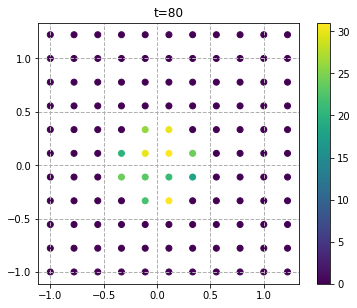

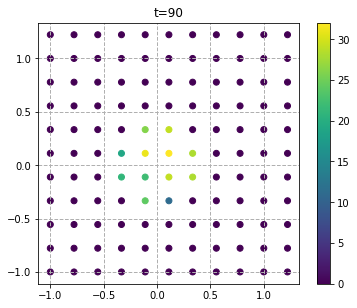

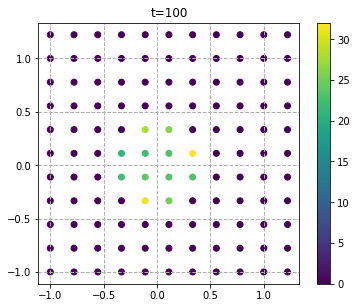

In [19]:
for i, t in enumerate(result.get_timespan()):
    if i % 10 == 0:
        result.plot_species("Cdc42_a", i, title=f"t={i}", use_matplotlib=True)